In [1]:
import os
import time
import random
import numpy as np

from scipy.stats import ortho_group


import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential
from torch import Tensor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import pickle

torch.set_default_dtype(torch.float64)

from torch_geometric.typing import (
    Adj,
    OptPairTensor,
    OptTensor,
    Size,
    SparseTensor,
    torch_sparse,
)

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse, to_undirected
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool, knn_graph
from torch_geometric.datasets import QM9
from torch_scatter import scatter
from torch_cluster import knn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import uproot
import vector
vector.register_awkward()
import awkward as ak

from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

ModuleNotFoundError: No module named 'torch_cluster'

### Extract the data and make graphs

In [2]:
pip install torch_cluster

  Using cached torch_cluster-1.6.3.tar.gz (54 kB)
  Preparing metadata (setup.py) ... done
anceled
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
class Jet_Dataset(data.Dataset):
    def __init__(self, dataset_path: str, k: int = 5) -> None:
        """
        Dataset for Jet Graphs:
            dataset_path: Path to the ROOT file containing jet data
            k: Number of nearest neighbors for KNN graph
        """
        super(Jet_Dataset, self).__init__()

        self.dataset = uproot.open(dataset_path)
        self.tree_names = [key for key in self.dataset.keys() if key.startswith("tree_")]
        self.trees = []
        self.k = k

        # Define jet features
        self.light_jet_feat = ["light_jet_pt", "light_jet_eta", "light_jet_phi", "light_jet_m", "light_jet_e"]
        self.c_jet_feat = ["c_jet_pt", "c_jet_eta", "c_jet_phi", "c_jet_m", "c_jet_e"]
        self.b_jet_feat = ["b_jet_pt", "b_jet_eta", "b_jet_phi", "b_jet_m", "b_jet_e"]

        self.graphs = []
        for tree_name in self.tree_names:
            tree = self.dataset[tree_name].arrays(library="ak")
            self.process_tree(tree)

    def process_tree(self, tree):
        # ocess a single tree and append each jet graph as an independent sample.
        def process_jet_features(jet_feat_list, label):
            if not all(feat in tree.fields for feat in jet_feat_list):
                return []

            graphs = []
            for i in range(len(tree[jet_feat_list[0]])):
                jet_features = np.stack(
                    [ak.to_numpy(tree[feat][i]) for feat in jet_feat_list], axis=-1
                )
                jet_features[np.isnan(jet_features)] = 0.0
                jet_features = torch.tensor(jet_features, dtype=torch.float32)
                global_features = self.compute_global_features(jet_features)

                if jet_features.shape[0] > 1:
                    eta = jet_features[:, 1]
                    phi = jet_features[:, 2]
                    edge_index, deltaR = self.calculate_edges(eta, phi)
                else:
                    edge_index = torch.tensor([], dtype=torch.long).view(2, -1)
                    deltaR = torch.tensor([])

                data = Data(x=jet_features, edge_index=edge_index, edge_deltaR=deltaR, global_features=global_features, label=torch.tensor(label))
                graphs.append(data)
            return graphs

        self.graphs += process_jet_features(self.light_jet_feat, label=0)
        self.graphs += process_jet_features(self.c_jet_feat, label=1)
        self.graphs += process_jet_features(self.b_jet_feat, label=2)

    def compute_global_features(self, jet_features):

        total_pt = torch.sum(jet_features[:, 0])
        avg_eta = torch.mean(jet_features[:, 1])
        avg_phi = torch.mean(jet_features[:, 2])
        total_energy = torch.sum(jet_features[:, 4])
        total_mass = torch.sum(jet_features[:, 3])
        num_particles = jet_features.shape[0]

        global_features = torch.tensor(
            [total_pt, avg_eta, avg_phi, total_energy, total_mass, num_particles],
            dtype=torch.float32
        ).view(1, -1)

        return global_features



    def calculate_edges(self, eta, phi):

        eta_phi = torch.stack([eta, phi], dim=-1)
        edge_index = torch_geometric.nn.pool.knn_graph(x=eta_phi, k=self.k)
        src, dst = edge_index
        delta_eta = eta[dst] - eta[src]
        delta_phi = phi[dst] - phi[src]
        deltaR = torch.hypot(delta_eta, delta_phi).view(-1, 1)
        return edge_index, deltaR

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

In [ ]:
root_file_path = "/home/pradeep/Desktop/PROJECT/jet_dataset.root"

# Initialize the dataset
dataset = Jet_Dataset(root_file_path)

# Print the first few graphs and their labels
# for i in range(5):
#     print(f"Graph {i}:")
#     print(jet_dataset[i])
#     print("Label:", jet_dataset[i].y)


In [ ]:
dataset[0]

Data(x=[8, 5], edge_index=[2, 40], edge_deltaR=[40, 1], global_features=[1, 6], label=0)

In [ ]:
a=Tensor([1])
b=Tensor([2])
c=Tensor([3])
a,b,c

(tensor([1.]), tensor([2.]), tensor([3.]))

In [ ]:
d=torch.stack((a,b,c),0).T
e=torch.tensor([a,b,c],dtype=torch.float32)

In [ ]:
d,e

(tensor([[1., 2., 3.]]), tensor([1., 2., 3.], dtype=torch.float32))

In [ ]:
len(dataset)

57873

In [ ]:
b=0
for batch in dataset:
    if batch.edge_deltaR is None:
        print(batch)
        b+=1
print(b)

0


In [ ]:
len(dataset)

57873

In [ ]:
print((dataset[0].edge_index).shape)
print(len(dataset[0].edge_deltaR))

torch.Size([2, 40])
40


In [ ]:
dataset[0]

Data(x=[8, 5], edge_index=[2, 40], edge_deltaR=[40, 1], global_features=[1, 6], label=0)

In [ ]:
labels = [data.label.tolist() for data in dataset]
print(f"jet labels: {Counter(labels)}")

jet labels: Counter({0: 48339, 1: 8255, 2: 1279})


### Data process

In [ ]:
# Use the loaded dataset
class PreprocessedJetDataset(torch.utils.data.Dataset):
    def __init__(self, graphs):
        super(PreprocessedJetDataset, self).__init__()
        self.graphs = graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

In [ ]:
### Downsample the dataset
import random

def balance_dataset(dataset):
    labels = [data.label.item() for data in dataset]
    label_counts = Counter(labels)

    min_count = min(label_counts.values())

    # Create a balanced dataset
    balanced_graphs = []
    for label in label_counts:
        class_graphs = [data for data in dataset if data.label.item() == label]

        balanced_graphs.extend(random.sample(class_graphs, min_count))

    return balanced_graphs


balanced_graphs = balance_dataset(dataset)
print(f"Balanced dataset size: {len(balanced_graphs)}")

balanced_dataset = PreprocessedJetDataset(balanced_graphs)


Balanced dataset size: 3837


In [ ]:
jet_dataset = balanced_dataset

In [ ]:
# Handle None case
a=0
for batch in jet_dataset:
    if batch.x is None:
        print(batch)
        a+=1
print(a)

0


In [ ]:
jet_dataset[0]

Data(x=[3, 5], edge_index=[2, 6], edge_deltaR=[6, 1], global_features=[1, 6], label=0)

In [ ]:
# Rename 'label' to 'y' for all data objects in the dataset
for data in jet_dataset:
    data.y = data.label
    del data.label


In [ ]:
jet_dataset[0]

Data(x=[3, 5], edge_index=[2, 6], edge_deltaR=[6, 1], global_features=[1, 6], y=0)

In [ ]:
jet_labels = [data.y.tolist() for data in jet_dataset]

print(f"Jet dataset labels: {Counter(jet_labels)}")

Jet dataset labels: Counter({0: 1279, 1: 1279, 2: 1279})


In [ ]:
from torch.utils.data import random_split

total_size = len(jet_dataset)

train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(balanced_dataset, [train_size, val_size, test_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Testing set size: {len(test_dataset)}")


Training set size: 2685
Validation set size: 575
Testing set size: 577


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Count labels in each split
train_labels = [data.y.tolist() for data in train_dataset]
val_labels = [data.y.tolist() for data in val_dataset]
test_labels = [data.y.tolist() for data in test_dataset]

print(f"Training labels: {Counter(train_labels)}")
print(f"Validation labels: {Counter(val_labels)}")
print(f"Test labels: {Counter(test_labels)}")


Training labels: Counter({1: 903, 0: 891, 2: 891})
Validation labels: Counter({0: 195, 2: 193, 1: 187})
Test labels: Counter({2: 195, 0: 193, 1: 189})


In [ ]:
# next(iter(train_loader))

In [ ]:
# # Handle None case
# for batch in train_loader:
#     if batch.edge_deltaR is None:
#         print(batch)


In [ ]:
# gr_b = next(iter(train_loader))
# gr_b

In [ ]:
# src_idx, dst_idx = gr_b.edge_index
# src, dst = gr_b.x[src_idx], gr_b.x[dst_idx]
# edge_attr = gr_b.edge_deltaR
# u = gr_b.global_features
# batch = gr_b.batch
# node_batch = gr_b.batch
# edge_batch = gr_b.batch[src_idx]

In [ ]:
# len(src), len(dst), len(edge_attr) ,src.shape, dst.shape, edge_attr.shape

In [ ]:
# print(f"src: {src.shape}")
# print(f"dst: {dst.shape}")
# print(f"edge_attr: {edge_attr.shape}")
# print(f"u: {u.shape}")
# print(F"batch: {batch.shape}")
# print(f"edge_batch size: {edge_batch.shape}")
# print("............................")
# print(len(u))
# print(len(batch))
# print(len(edge_batch))

In [ ]:
# print(f"x data type: {gr_b.x.dtype}")
# print(f"src data type: {src.dtype}")
# print(f"dst data type: {dst.dtype}")
# print(f"edge_attr data type: {edge_attr.dtype}")
# print(f"u data type: {u.dtype}")
# print(F"batch data type: {batch.dtype}")

In [ ]:
# c = [data.tolist() for data in u]

# print(f"Jet dataset labels: {Counter(jet_labels)}")

In [ ]:
# print(f"src: {src.shape}")
# print(f"dst: {dst.shape}")
# print(f"edge_attr: {edge_attr.shape}")
# print(f"u: {u.shape}")
# print(F"batch: {batch.shape}")
# print(len(u))
# print(len(batch))

In [ ]:
# torch.cat([src, dst, edge_attr,u[edge_batch]], dim=1)

In [ ]:
# a=0
# for batch in val_loader:
#         edge_attr = batch.edge_deltaR
#         src_idx, dst_idx = batch.edge_index
#         src, dst = batch.x[src_idx], batch.x[dst_idx]
#         edge_batch = batch.batch[src_idx]
#         u = batch.global_features
#         node_batch = batch.batch
#         s = len(src)
#         d = len(dst)
#         e = len(edge_attr)
#         ul = len(u[edge_batch])
#         out = torch.cat([src, dst, edge_attr, u[edge_batch]], dim=1)
#         if not (s == d == e == ul):
#                 a+=1
#         if (e == 1905):
#                 print(f"{s}, {d}, {e}, {ul}")

# print(a)

### Model

In [ ]:
#mlp = multi layer preceptron
def build_mlp(inputsize,outputsize,features,add_batch_norm=False,add_activation=None):
    layers = []
    layers.append(nn.Linear(inputsize,features[0]))
    layers.append(nn.ReLU())
    for hidden_i in range(1,len(features)):
        if add_batch_norm:
            layers.append(nn.BatchNorm1d(features[hidden_i-1]))
        layers.append(nn.Linear(features[hidden_i-1],features[hidden_i]))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(features[-1],outputsize))
    if add_activation!=None:
        layers.append(add_activation)
    return nn.Sequential(*layers)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MetaLayer

class EdgeModel(nn.Module):
    def __init__(self, input_edge_dim, input_node_dim, input_global_dim, output_edge_dim, hidden_dims):
        super(EdgeModel, self).__init__()
        self.edge_mlp = build_mlp(inputsize=input_edge_dim + 2 * input_node_dim + input_global_dim,
                                  outputsize=output_edge_dim,
                                  features=hidden_dims)

    def forward(self, src, dst, edge_attr, u, batch):
        out = torch.cat([src, dst, edge_attr, u[edge_batch]], dim=1)
        return self.edge_mlp(out)

class NodeModel(nn.Module):
    def __init__(self, input_edge_dim, input_node_dim, input_global_dim, output_node_dim, hidden_dims):
        super(NodeModel, self).__init__()
        self.node_mlp = build_mlp(inputsize=input_edge_dim + input_node_dim + input_global_dim,
                                  outputsize=output_node_dim,
                                  features=hidden_dims)

    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        agg = scatter(edge_attr, row, dim=0, reduce='mean')
        out = torch.cat([x, agg, u[batch]], dim=1)
        return self.node_mlp(out)

class GlobalModel(nn.Module):
    def __init__(self, input_edge_dim, input_node_dim, input_global_dim, output_global_dim, hidden_dims):
        super(GlobalModel, self).__init__()
        self.global_mlp = build_mlp(inputsize=input_edge_dim + input_node_dim + input_global_dim,
                                    outputsize=output_global_dim,
                                    features=hidden_dims)

    def forward(self, x, edge_index, edge_attr, u, batch):
        edge_agg = scatter(edge_attr, batch[src_idx], dim=0, reduce='mean')
        node_agg = scatter(x, batch, dim=0, reduce='mean')
        out = torch.cat([u, node_agg, edge_agg], dim=1)
        return self.global_mlp(out)

class GNNModel(nn.Module):
    def __init__(self, input_edge_dim, input_node_dim, input_global_dim, output_dim, hidden_dims):
        super(GNNModel, self).__init__()
        self.meta_layer = MetaLayer(
            edge_model=EdgeModel(input_edge_dim, input_node_dim, input_global_dim, hidden_dims[0], hidden_dims),
            node_model=NodeModel(hidden_dims[0], input_node_dim, input_global_dim, hidden_dims[1], hidden_dims),
            global_model=GlobalModel(hidden_dims[0], hidden_dims[1], input_global_dim, hidden_dims[2], hidden_dims)
        )
        self.output_layer = nn.Linear(hidden_dims[2], output_dim)

    def forward(self, x, edge_index, edge_attr, u, batch):
        x, edge_attr, u = self.meta_layer(x, edge_index, edge_attr, u, batch)
        out = self.output_layer(u)
        return out


In [ ]:
import torch
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Hyperparameters
num_epochs = 50
learning_rate = 0.001
hidden_dims = [32, 64, 64]
output_dim = 3
input_edge_dim = 1
input_node_dim = 5
input_global_dim = 6

# Create the model
model = GNNModel(input_edge_dim, input_node_dim, input_global_dim, output_dim, hidden_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
model = model.float()

# Training Loop
train_losses, val_losses, accuracies = [], [], []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        edge_attr = batch.edge_deltaR
        src_idx, dst_idx = batch.edge_index
        src, dst = batch.x[src_idx], batch.x[dst_idx]
        edge_batch = batch.batch[src_idx]
        u = batch.global_features
        node_batch = batch.batch
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, edge_attr,u , batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))


    model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            edge_attr = batch.edge_deltaR
            src_idx, dst_idx = batch.edge_index
            src, dst = batch.x[src_idx], batch.x[dst_idx]
            edge_batch = batch.batch[src_idx]
            u = batch.global_features
            node_batch = batch.batch
            out = model(batch.x, batch.edge_index, edge_attr, u, batch.batch)
            loss = criterion(out, batch.y)
            test_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)

    val_losses.append(test_loss / len(test_loader))
    accuracies.append(correct / total)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, val Loss: {val_losses[-1]:.4f},val Accuracy: {accuracies[-1]:.4f}")


torch.save(model.state_dict(), "gnn_model.pth")


Epoch 1/50, Train Loss: 0.8621, val Loss: 0.5672,val Accuracy: 0.7565
Epoch 2/50, Train Loss: 0.5021, val Loss: 0.3753,val Accuracy: 0.8504
Epoch 3/50, Train Loss: 0.4489, val Loss: 0.3519,val Accuracy: 0.8539
Epoch 4/50, Train Loss: 0.3970, val Loss: 0.2997,val Accuracy: 0.8922
Epoch 5/50, Train Loss: 0.3820, val Loss: 0.3204,val Accuracy: 0.8678
Epoch 6/50, Train Loss: 0.3730, val Loss: 0.2827,val Accuracy: 0.8800
Epoch 7/50, Train Loss: 0.3534, val Loss: 0.2766,val Accuracy: 0.8957
Epoch 8/50, Train Loss: 0.3360, val Loss: 0.2942,val Accuracy: 0.8904
Epoch 9/50, Train Loss: 0.3320, val Loss: 0.3009,val Accuracy: 0.8800
Epoch 10/50, Train Loss: 0.3220, val Loss: 0.3139,val Accuracy: 0.8591
Epoch 11/50, Train Loss: 0.3301, val Loss: 0.2975,val Accuracy: 0.8730
Epoch 12/50, Train Loss: 0.3257, val Loss: 0.2920,val Accuracy: 0.8765
Epoch 13/50, Train Loss: 0.3201, val Loss: 0.2892,val Accuracy: 0.8696
Epoch 14/50, Train Loss: 0.3210, val Loss: 0.2939,val Accuracy: 0.8765
Epoch 15/50, Tr

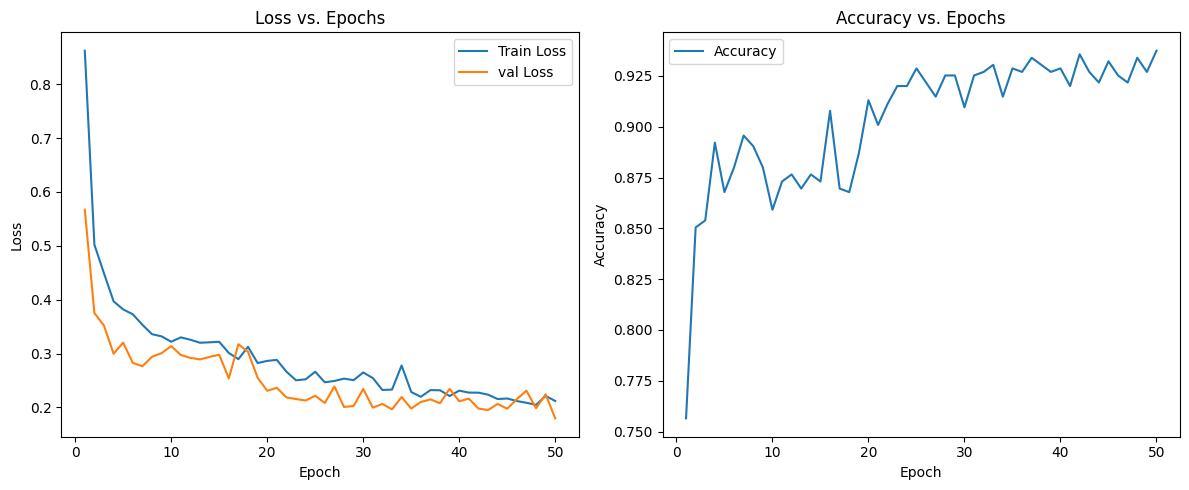

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.tight_layout()
plt.show()


Test Accuracy: 0.9463


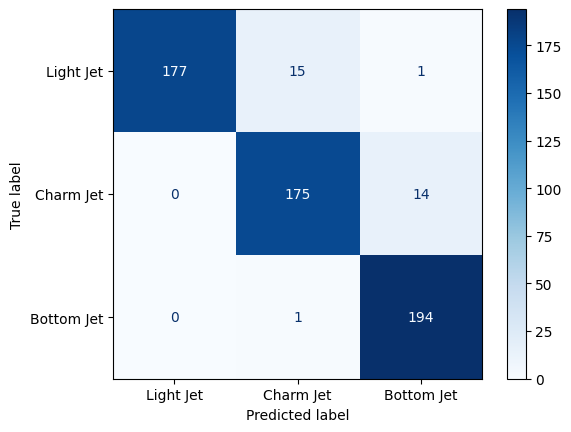

In [ ]:
# test the model
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        edge_attr = batch.edge_deltaR
        src_idx, dst_idx = batch.edge_index
        src, dst = batch.x[src_idx], batch.x[dst_idx]
        edge_batch = batch.batch[src_idx]
        u = batch.global_features
        node_batch = batch.batch
        out = model(batch.x, batch.edge_index, edge_attr, u, batch.batch)
        preds = out.argmax(dim=1)
        all_preds.append(preds)
        all_labels.append(batch.y)

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Light Jet", "Charm Jet", "Bottom Jet"])
disp.plot(cmap="Blues")
plt.show()